# Social Network Analysis - Assortativity

## 1. Project Goal

In this project, a network dataset will be analyzed as to discover <b>gender</b>'s influence on how communications, information, and decisions flow through an organization. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import igraph as ig
import networkx as nx
from scipy.stats import ttest_ind
from mlxtend.evaluate import permutation_test
import seaborn as sns

## 1. Descriptive Gender Analysis

In [2]:
#Load data into dataframe
nodes = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Nodes with attributes.csv')
link = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Links - Intragroup.csv')
nodes_all = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Nodes with attributes.csv')
#Select columns of interst from node data 
nodes = nodes[['ID','Gender']]

#Out-degree statistics by Gender and Label
link_source = link.rename(columns = {'Source': "ID"})
out_degree = pd.merge(link_source,nodes,how='left',on = 'ID')
by_label_out_degree = out_degree.groupby(['Gender','Label']).ID.count().reset_index()

#In-degree statistics by Gender and Label
link_source2 = link.rename(columns = {"Target":"ID"})
in_degree = pd.merge(link_source2,nodes,how='left',on = 'ID')
by_label_in_degree = in_degree.groupby(['Gender','Label']).ID.count().reset_index()

#Gender to gender in and out degree statistics 
in_degree.rename(columns = {'Gender': 'Gender_in','ID': 'Target2','Source':'Source2','Label':'Label2'},inplace=True)
out_degree.rename(columns = {'Gender': 'Gender_out','ID': 'Source'},inplace=True)
combined = pd.concat([out_degree,in_degree],axis=1)
combined = combined[['Source','Target','Label','Gender_out','Gender_in']]
gender_to_gender = combined.groupby(['Gender_out','Gender_in']).Source.count().reset_index()

In [124]:
nodes

,ID,Gender,ID2
0,428634,Female,0
1,428764,Female,1
2,428881,Female,2
3,428738,Female,3
4,428803,Female,4
...,...,...,...
607,428244,Female,607
608,428192,Male,608
609,428231,Male,609
610,442219,Male,610


In [3]:
#print a number of out-degree by gender and label
by_label_out_degree

,Gender,Label,ID
0,Female,Access,96
1,Female,Career Development,165
2,Female,Decision Making,230
3,Female,Energy,321
4,Female,Innovation,220
5,Female,Personal Support,234
6,Female,Problem Solving,298
7,Female,Strategy,196
8,Female,Trust,274
9,Male,Access,133


In [4]:
#print a number of in-degree by gender and label
by_label_in_degree

,Gender,Label,ID
0,Female,Access,62
1,Female,Career Development,135
2,Female,Decision Making,199
3,Female,Energy,308
4,Female,Innovation,198
5,Female,Personal Support,213
6,Female,Problem Solving,247
7,Female,Strategy,117
8,Female,Trust,237
9,Male,Access,167


In [5]:
#print a number of degrees between genders
gender_to_gender

,Gender_out,Gender_in,Source
0,Female,Female,1010
1,Female,Male,1024
2,Male,Female,706
3,Male,Male,2353


In [6]:
#Gender to gender statistics by label
label = combined['Label'].unique()
for i in range(0,len(label)):
    sector = combined[combined['Label'] == label[i]]
    a = sector.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
    b= print('{0}'.format(label[i]),a)

Energy   Gender_out Gender_in  Source
0     Female    Female     190
1     Female      Male     131
2       Male    Female     118
3       Male      Male     327
Trust   Gender_out Gender_in  Source
0     Female    Female     137
1     Female      Male     137
2       Male    Female     100
3       Male      Male     330
Career Development   Gender_out Gender_in  Source
0     Female    Female      81
1     Female      Male      84
2       Male    Female      54
3       Male      Male     182
Personal Support   Gender_out Gender_in  Source
0     Female    Female     154
1     Female      Male      80
2       Male    Female      59
3       Male      Male     201
Decision Making   Gender_out Gender_in  Source
0     Female    Female     114
1     Female      Male     116
2       Male    Female      85
3       Male      Male     294
Access   Gender_out Gender_in  Source
0     Female    Female      34
1     Female      Male      62
2       Male    Female      28
3       Male      Male     10

## 2. Gender Assortativity 

The assortativity coeffiicent was used to quantify the extent to which gender plays a role in networking. The assortativity coeffiicent gauges the correlation between chracteristics of connected nodes in a network just as the Pearson correlation coefficient does: A value always falls bewteen -1 and 1. A postitive assortativity coefficient indicates that similar nodes tend to connect to each other. 

In [7]:
#Link data preprocessing
a = [i for i in range(0,612)]
nodes['ID2']= a
nodes2 = nodes.rename(columns = {'ID':'Target','ID2':'ID_Target'})
link2 = link[['Source','Target']]
link2 = link2.rename(columns = {'Source' : 'ID'})
link3 = pd.merge(link2,nodes,how='left')
link4 = pd.merge(link3,nodes2,how='left',on='Target')
link_final = link4[['ID2','ID_Target']]
link_final = link_final.rename(columns = {'ID2':'Source','ID_Target':'Target'})
link_final['link'] = list(zip(link_final['Source'],link_final['Target']))
link_final = link_final['link']

#Node data preprocessing
nodes_network = nodes[['ID','Gender']]
nodes_network['Gender2'] = nodes_network['Gender'].map({'Male':1, 'Female':2})

#Creating a network and compute the assortativity
nodes_network['ID'] = [i for i in range(0,612)]
g = ig.Graph()
g.add_vertices([i for i in range(0,612)])
g.add_edges(link_final)
g.vs['Gender'] = nodes_network['Gender2']
print('The assortativity of the network is {0}'.format(g.assortativity_nominal('Gender',directed=True)))

The assortativity of the network is 0.26986616946343467


<b>Conclusion:</b><br>
   The assortativity coefficient of the network is 0.2698, which indicates that there are more edges between same genders compared to a random network. The strength of assortativity is 'weak'. 

## 3. Gender Assortativity By Label
The assortativity coefficients were calculated based on 'label'. 

In [8]:
#Link data preprocessing
link_label = link[['Source','Target','Label']]
link_label = link_label.rename(columns = {'Source' : 'ID'})
link_label2=pd.merge(link_label,nodes,how='left')
link_label3 = pd.merge(link_label2,nodes2,how='left', on='Target')
link_label_final = link_label3[['ID2','ID_Target','Label']]
link_label_final = link_label_final.rename(columns = {'ID2': 'Source','ID_Target':'Target'})
link_label_final['link'] = list(zip(link_label_final['Source'],link_label_final['Target']))
link_label_final2 = link_label_final[['link','Label']]

#create link data with label
labels = link_label_final2['Label'].unique()
link_data_by_label = []
for label in labels:
    new_label = link_label_final2[link_label_final2['Label'] == label]
    link_data_by_label.append(new_label)
    
    
#create a network and compute the assortativity by label    
node_final = [i for i in range(0,612)]
assortativity=[]
for datum in link_data_by_label:
    g = ig.Graph()
    g.add_vertices(node_final)
    g.add_edges(datum['link'])
    g.vs['Gender'] = nodes_network['Gender2']
    temp = g.assortativity_nominal('Gender',directed = True)
    assortativity.append(temp)
    
assortativity_label = {key: value for key, value in zip(labels,assortativity)}

In [9]:
#print assortativity by label
assortativity_label

{'Energy': 0.32838603700436797,
 'Trust': 0.27198947568214993,
 'Career Development': 0.2650996015936256,
 'Personal Support': 0.4321064231868238,
 'Decision Making': 0.276715679757505,
 'Access': 0.1303797468354431,
 'Innovation': 0.23365849436840877,
 'Problem Solving': 0.24722893422027978,
 'Strategy': 0.0722488805555895}

<b>Conclusion:</b><br>
Assortativity is high for 'Personal Support', 'Energy'and 'Decision Making'. 

## 4. The difference in the number of out-degrees between men and women 

In this chapter, we examined the difference in the number of out-degrees between men and women from the sample and tested if the difference is statistically significance by running permutation tests. 

In [11]:
#preprocessing the data 
out_label = link_label_final[['Source','Label']]
out_label = out_label.rename(columns = {'Source':'ID'})
out_label_gender = pd.merge(out_label,nodes_network,how = 'left',on = 'ID')
out_label_male = out_label_gender[out_label_gender['Gender'] == 'Male']
out_label_female = out_label_gender[out_label_gender['Gender'] == 'Female']
number_degree_male = out_label_male.groupby(['ID']).Gender.count().reset_index()
number_degree_male = number_degree_male.rename(columns = {'Gender': 'Number of out-degree'})
number_degree_female = out_label_female.groupby(['ID']).Gender.count().reset_index()
number_degree_female = number_degree_female.rename(columns = {'Gender':'Number of out-degree'})
number_degree_male2 = number_degree_male['Number of out-degree']
number_degree_female2 = number_degree_female['Number of out-degree']

In [12]:
#split the data into men and women in terms of # of out-degress 
nodes_network_male = nodes_network[nodes_network['Gender']=='Male']
nodes_network_male21 = pd.merge(nodes_network_male,number_degree_male,how='left',on = 'ID')
nodes_network_male2=nodes_network_male21.fillna(0)
nodes_network_female = nodes_network[nodes_network['Gender']=='Female']
nodes_network_female21 = pd.merge(nodes_network_female,number_degree_female,how='left',on = 'ID')
nodes_network_female2=nodes_network_female21.fillna(0)
nodes_network_male2 = nodes_network_male2['Number of out-degree']
nodes_network_female2 = nodes_network_female2['Number of out-degree']

Text(0.5, 1.0, 'Number of Out-degree by Gender')

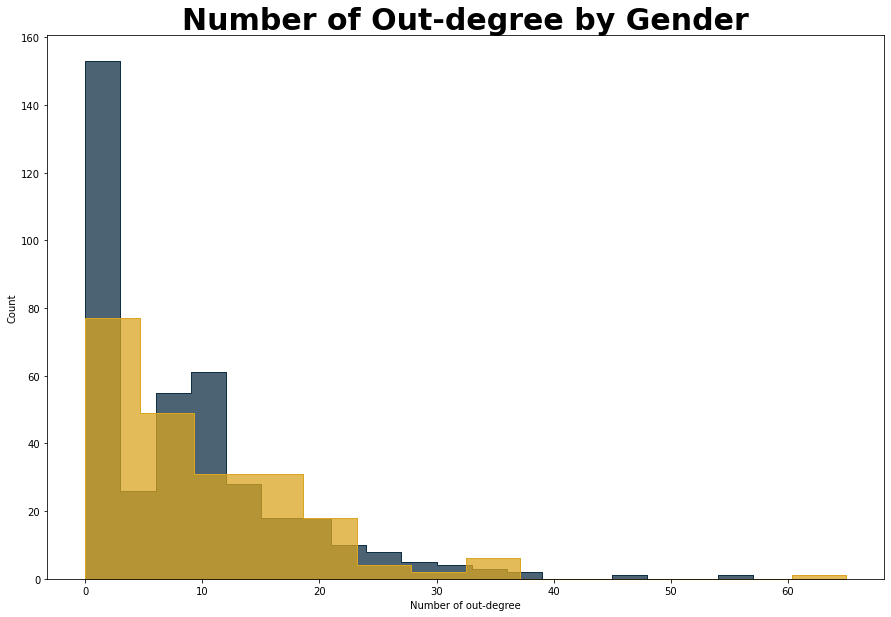

In [74]:
f,ax = plt.subplots(figsize = (15,10))
sns.histplot(nodes_network_male2,element='step',color='#0e2f44')
sns.histplot(nodes_network_female2,element = 'step',color='#daa520')

ax.set_title('Number of Out-degree by Gender',fontweight = 'bold',fontsize=30)

## Permutation test on the average out-degree between male and female groups 

In [98]:
tstat,pval_ttest_out2 = ttest_ind(nodes_network_male2,nodes_network_female2)
p_val_permu_out2 = permutation_test(nodes_network_male2,nodes_network_female2,method='approximate',num_rounds = 10000,seed=0)

In [99]:
pval_ttest_out2

0.04646645411248457

In [100]:
p_val_permu_out2

0.0471952804719528

<b>Conclusion:</b><br>
A p-value of .047 indicates that we would see the observed sample result only 4.7% of the time under the assumption that there's no difference in the average out-degrees between men and women. Thus we reject the null hypothesis indicating that there's a statistically significant different in the number of out-degrees betweeen men and women based on 0.05 threshold. 

## 4. The difference in the number of in-degrees between men and women 

The difference in the number of in-degrees between men and women was calculated. 

In [93]:
in_label = link_label_final[['Target','Label']]
in_label =in_label.rename(columns ={'Target':'ID'})
in_label_gender = pd.merge(in_label,nodes_network,how='left',on='ID')
in_label_male = in_label_gender[in_label_gender['Gender'] =='Male']
in_label_female = in_label_gender[in_label_gender['Gender'] =='Female']
number_in_male = in_label_male.groupby(['ID']).Gender.count().reset_index()
number_in_female = in_label_female.groupby(['ID']).Gender.count().reset_index()
number_in_male = number_in_male.rename(columns = {'Gender': 'Number of in-degree'})
number_in_female = number_in_female.rename(columns = {'Gender': 'Number of in-degree'})
nodes_network_male_in = nodes_network[nodes_network['Gender']=='Male']
nodes_network_male2_in = pd.merge(nodes_network_male_in,number_in_male,how='left',on = 'ID')
nodes_network_male3_in = nodes_network_male2_in.fillna(0)
nodes_network_female_in = nodes_network[nodes_network['Gender']=='Female']
nodes_network_female2_in = pd.merge(nodes_network_female_in,number_in_female,how='left',on = 'ID')
nodes_network_female3_in=nodes_network_female2_in.fillna(0)
nodes_network_male3_in = nodes_network_male3_in['Number of in-degree']
nodes_network_female3_in = nodes_network_female3_in['Number of in-degree']

Text(0.5, 1.0, 'Number of In-degree by Gender')

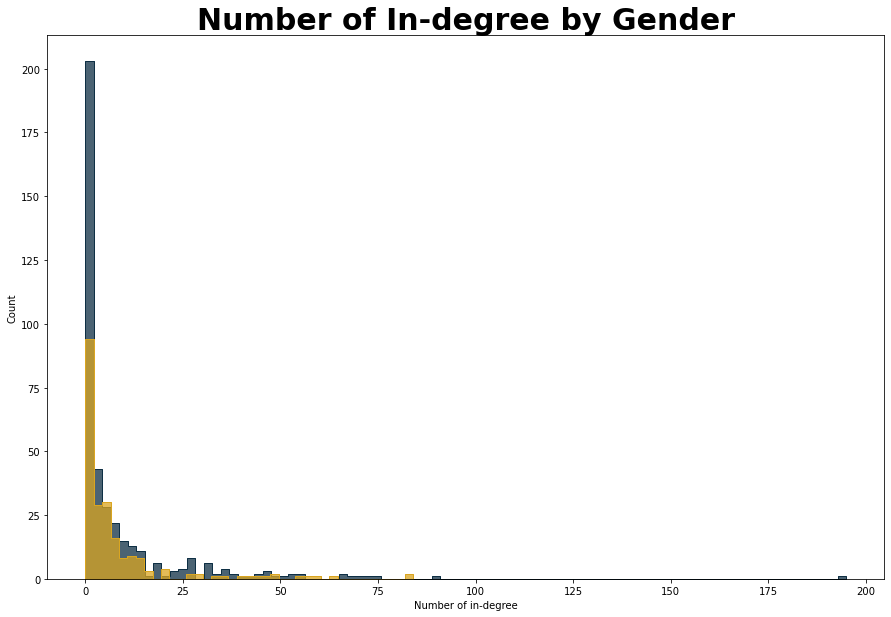

In [94]:
f,ax = plt.subplots(figsize = (15,10))
sns.histplot(nodes_network_male3_in,element='step',color='#0e2f44')
sns.histplot(nodes_network_female3_in,element = 'step',color='#daa520')

ax.set_title('Number of In-degree by Gender',fontweight = 'bold',fontsize=30)

## Permutation test on the average In-degree between male and female group

In [88]:
tstat,pval_ttest_in2 = ttest_ind(nodes_network_male3_in,nodes_network_female3_in)
p_val_permu_in2 = permutation_test(nodes_network_male3_in,nodes_network_female3_in,method='approximate',num_rounds = 10000,seed=0)

In [89]:
pval_ttest_in2

0.5712703414065738

In [90]:
p_val_permu_in2

0.5823417658234177

<b>Conclusion:</b><br>
The p-value for the number of in-degrees is 0.58, which is greater than 0.05. We failed to reject the null hypothesis; in our smaple women have a higher connections, but this result is not statistically significant. 

## Number of in-degree by Gender (without outliers)

We visually detected a couple of outliers from the histograms aboves. Since these outliers tend to be more seniors, they migth have been responsible for having more connections. Assuming that this interpretation is true, we thought that eliminating outliers might help reduce noise.  

In [101]:
number_in_male_outlier = number_in_male[number_in_male['ID'] !=610]
number_in_female_outlier = number_in_female[number_in_female['ID'] != 607]
nodes_network_male_in = nodes_network[nodes_network['Gender']=='Male']
nodes_network_male_in = nodes_network_male_in[nodes_network_male_in['ID']!=610]
nodes_network_male2_in = pd.merge(nodes_network_male_in,number_in_male_outlier,how='left',on = 'ID')
nodes_network_male3_in = nodes_network_male2_in.fillna(0)
nodes_network_female_in = nodes_network[nodes_network['Gender']=='Female']
nodes_network_female_in = nodes_network_female_in[nodes_network_female_in['ID'] != 607]
nodes_network_female2_in = pd.merge(nodes_network_female_in,number_in_female_outlier,how='left',on = 'ID')
nodes_network_female3_in=nodes_network_female2_in.fillna(0)
nodes_network_male3_in_o = nodes_network_male3_in['Number of in-degree']
nodes_network_female3_in_o = nodes_network_female3_in['Number of in-degree']


Text(0.5, 1.0, 'Number of In-degree by Gender')

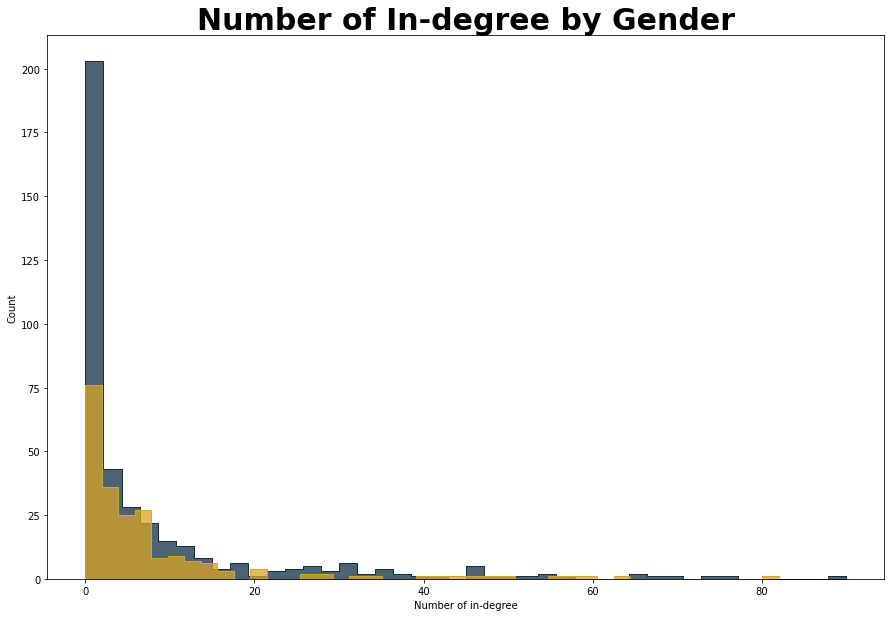

In [102]:
f,ax = plt.subplots(figsize = (15,10))
sns.histplot(nodes_network_male3_in_o,element='step',color='#0e2f44')
sns.histplot(nodes_network_female3_in_o,element = 'step',color='#daa520')

ax.set_title('Number of In-degree by Gender',fontweight = 'bold',fontsize=30)

In [103]:
tstat,pval_ttest_in2 = ttest_ind(nodes_network_male3_in_o,nodes_network_female3_in_o)
p_val_permu_in2 = permutation_test(nodes_network_male3_in_o,nodes_network_female3_in_o,method='approximate',num_rounds = 10000,seed=0)

In [104]:
pval_ttest_in2

0.5833244325643967

In [105]:
p_val_permu_in2

0.5807419258074192

<b>Conclusion:</b><br>
Even without top 3 outliers from both men and women groups, the p-value of .58 tells us that there's no statistical significant differences in the number of in-dgrees between them. 

In [106]:
print('average number of in-degrees for male without an outlier: {0}'.format(nodes_network_male3_in_o.mean()))

average number of in-degrees for male without an outlier: 8.11734693877551


In [40]:
print('average number of in-degrees for female without an outlier: {0}'.format(nodes_network_female3_in_o.mean()))

average number of in-degrees for female without an outlier: 7.486238532110092


## Number of Out-degrees by 'Gender' and 'LabeL'
raw data: out_label_gender  -> out_label_male , out_label_female

In [107]:
#number of out-degrees by gender and label
number_degree_male_label = out_label_male.groupby(['ID','Label']).Gender.count().reset_index()
number_degree_female_label = out_label_female.groupby(['ID','Label']).Gender.count().reset_index()

#group the above data by label 
out_data_label_male = []
for label in labels:
    new_label = number_degree_male_label[number_degree_male_label['Label'] == label]
    out_data_label_male.append(new_label)
    
out_data_label_female = []
for label in labels:
    new_label = number_degree_female_label[number_degree_female_label['Label'] == label]
    out_data_label_female.append(new_label)

    
#permutation test to see if there's significant difference in the average number of out-degrees by gender and label
p_val_permu_out_label = []
for i in range(9):
    p_val_permu_out_label.append(permutation_test(out_data_label_male[i].Gender,out_data_label_female[i].Gender,method='approximate',num_rounds = 10000,seed=0))

#create a list: (label,p-value)
p_val_by_label = [(label,pval) for label, pval in list(zip(labels,p_val_permu_out_label))]

print('p-values for difference in averge out-degree by label')
p_val_by_label

p-values for difference in averge out-degree by label


[('Energy', 0.11018898110188981),
 ('Trust', 0.616938306169383),
 ('Career Development', 0.31786821317868214),
 ('Personal Support', 0.0034996500349965005),
 ('Decision Making', 0.9222077792220778),
 ('Access', 0.51994800519948),
 ('Innovation', 0.7030296970302969),
 ('Problem Solving', 0.7081291870812919),
 ('Strategy', 0.37066293370662934)]


For only personal support, there's a statistical significance in # of outdegree difference between men and women

In [108]:
#average number of out-degrees by gender and label
mean_by_label_male = []
mean_by_label_female = []
for i in range(9):
    mean_by_label_male.append(out_data_label_male[i].Gender.mean())
    mean_by_label_female.append(out_data_label_female[i].Gender.mean())
mean_by_label = list(zip(mean_by_label_male,mean_by_label_female))

#create a list: [label,mean(men,women)]
mean_by_label = [(label,mean) for label,mean in zip(labels,mean_by_label)]

#print the list
print('average # of out-degrees for men and women by label ')
mean_by_label

average # of out-degrees for men and women by label 


[('Energy', (2.109004739336493, 2.450381679389313)),
 ('Trust', (1.9907407407407407, 2.0757575757575757)),
 ('Career Development', (1.4047619047619047, 1.5137614678899083)),
 ('Personal Support', (1.6049382716049383, 2.0172413793103448)),
 ('Decision Making', (1.730593607305936, 1.7164179104477613)),
 ('Access', (1.75, 1.9591836734693877)),
 ('Innovation', (2.1123595505617976, 2.018348623853211)),
 ('Problem Solving', (2.0688073394495414, 2.143884892086331)),
 ('Strategy', (1.6778846153846154, 1.5555555555555556))]

As can be seen, other areas have simliar average connections betweeen men and women except 'Personal Support'

## Gender Assortativity by Division

In [50]:
nodes_all2 = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Nodes with attributes_V2.csv')

In [51]:
nodes_all2.columns

Index(['ID', 'Full Name', 'Invited', 'Responded', 'Organization', 'Division',
       'Function/Deparment', 'Title', 'Level', 'Location', 'Tenure', 'Manager',
       'Team', 'Gender', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27'],
      dtype='object')

In [52]:
#select columns of interst from node data 
nodes_div = nodes_all2[['ID','Gender','Division']]

#drop rows with N/A
nodes_div.dropna(subset=['ID','Gender','Division'],inplace = True)

#add a ID2 column with a series:(0,612)
nodes_div['ID2']= a
nodes_div_temp = nodes_div

#rearrange the order of columns
nodes_div_temp = nodes_div_temp[['ID2','Gender','Division']]


#encode the gender variable
nodes_div_temp['Gender2'] = nodes_div_temp['Gender'].map({'Male':1,'Female':2})

#create a division name list
divisions = nodes_div.Division.unique()
nodes_division = []
for division in divisions:
    nodes_division.append(nodes_div_temp[nodes_div_temp['Division'] == division])
    

#create a division size list
division_size = []
for i in range(len(divisions)):
    division_size.append(len(nodes_division[i]))


#combine division names and division size into a list
division_size = [(divisions,size) for divisions,size in list(zip(divisions,division_size))]

<ipython-input-52-aceb3dc02e28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_div.dropna(subset=['ID','Gender','Division'],inplace = True)
<ipython-input-52-aceb3dc02e28>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_div['ID2']= a


In [53]:
#Link data preprocessing
nodes_div2 = nodes_div.rename(columns = {'ID':'Target','ID2':'ID_Target'})
link_div = link[['Source','Target']]
link_div = link_div.rename(columns = {'Source' : 'ID'})
link_div2 = pd.merge(link_div,nodes_div,how='left')
link_div3 = pd.merge(link_div2,nodes_div2,how='left',on='Target')
link_div4 = link_div3[['ID2','ID_Target','Division_x']]
link_final_div = link_div4.rename(columns = {'ID2':'Source','ID_Target':'Target','Division_x':'Division_source'})
link_final_div['link'] = list(zip(link_final_div['Source'],link_final_div['Target']))
link_final_div = link_final_div[['link','Division_source']]

link_by_div = []
for division in divisions:
    link_by_div.append(link_final_div[link_final_div['Division_source'] == division])

In [54]:
total_div = []
male_female_div = []
male_male_div = []
female_male_div = []
female_female_div = []
for i in range(len(divisions)):
    total_div.append(len(link_div3[link_div3['Division_x']==divisions[i]]))
    male_female_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Male') &(link_div3['Gender_y'] =='Female')]))
    male_male_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Male') &(link_div3['Gender_y'] =='Male')]))
    female_female_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Female') &(link_div3['Gender_y'] =='Female')]))
    female_male_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Female') &(link_div3['Gender_y'] =='Male')]))

link_distribution_division = pd.DataFrame(list(zip(total_div,male_male_div,male_female_div,female_female_div,female_male_div)),columns = ['total links','male to male','male to female','female to female','female to male'],
                                         index = [division for division in divisions ])
    

In [55]:
#Creating a network and compute the assortativity
assort_by_div = []
for i in range(len(divisions)):
    g1 = ig.Graph()
    g1.add_vertices([i for i in range(0,612)])
    g1.add_edges(link_by_div[i]['link'])
    g1.vs['Gender'] = nodes_network['Gender2']
    assort_by_div.append(g1.assortativity_nominal('Gender',directed=True))

assort_div = [(division,assortativity) for division,assortativity in zip(divisions,assort_by_div)]

In [56]:
assort_by_div

[0.3818930426238713,
 0.20319246100685065,
 0.055196360153256706,
 0.022812393598910505,
 0.13928579015571557,
 0.21015983076742273,
 0.12218475061223537,
 0.08910256410256412,
 -0.1069615069615072]

In [57]:
assort_div

[('Andrew Corkum', 0.3818930426238713),
 ('Bob Bolger', 0.20319246100685065),
 ('Dennis Bassett', 0.055196360153256706),
 ('Glen Tinevez', 0.022812393598910505),
 ('John Meckles', 0.13928579015571557),
 ('Kristy Hanson', 0.21015983076742273),
 ('Patrick Rigby', 0.12218475061223537),
 ('Timothy Adams', 0.08910256410256412),
 ('Michael Iskra', -0.1069615069615072)]

In [109]:
link_distribution_division['Assortativity'] = assort_by_div

In [110]:
link_distribution_division

,total links,male to male,male to female,female to female,female to male,Assortativity
Andrew Corkum,327,109,49,117,52,0.381893
Bob Bolger,826,242,61,255,268,0.203192
Dennis Bassett,607,145,154,176,132,0.055196
Glen Tinevez,205,88,21,26,70,0.022812
John Meckles,509,232,82,78,117,0.139286
Kristy Hanson,522,151,108,165,98,0.210160
Patrick Rigby,1351,1129,75,25,122,0.122185
Timothy Adams,637,180,135,167,155,0.089103
Michael Iskra,109,77,21,1,10,-0.106962


## Difference in Average # of out-degrees by Level

In [59]:
#select columns of interst from node data 
nodes_level = nodes_all2[['ID','Gender','Level']]

#drop rows with N/A
nodes_level.dropna(subset=['ID','Gender','Level'],inplace = True)

#add a ID2 column with a series:(0,612)
nodes_level['ID2']= a
nodes_level_temp = nodes_level


#rearrange the order of columns
nodes_level_temp = nodes_level_temp[['ID2','Gender','Level']]


#encode the gender variable
nodes_level_temp['Gender2'] = nodes_level_temp['Gender'].map({'Male':1,'Female':2})
nodes_level_temp_male = nodes_level_temp[nodes_level_temp['Gender'] =='Male'].rename(columns = {'ID2':'ID'})
nodes_level_temp_female = nodes_level_temp[nodes_level_temp['Gender'] =='Female'].rename(columns = {'ID2': 'ID'})


nodes_level_temp = nodes_level_temp.rename(columns={'ID2':'Source'})
nodes_level_temp2 = nodes_level_temp.rename(columns={'Source': 'Target'})

nodes_level2 = nodes_level.rename(columns = {'ID':'Target','ID2':'ID_Target'})



<ipython-input-59-b6f260a1b386>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_level.dropna(subset=['ID','Gender','Level'],inplace = True)
<ipython-input-59-b6f260a1b386>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_level['ID2']= a


In [60]:
#link data preprocessing - male
link_level_male = pd.merge(nodes_network_male21,nodes_level_temp_male,how='left')
link_level_male = link_level_male.fillna(0)

#link data preprocessing - female
link_level_female = pd.merge(nodes_network_female21,nodes_level_temp_female,how='left')
link_level_female = link_level_female.fillna(0)


#break gender data in different levels
level_male_data = []
for i in range(1,6):
    level_male_data.append(link_level_male[link_level_male['Level'] == i])
    
level_female_data = []
for i in range(1,6):
    level_female_data.append(link_level_female[link_level_female['Level'] == i])
    
pval_by_level = []
pval_by_level_t = []
for i in range(0,5):
     pval_by_level.append(permutation_test(level_male_data[i]['Number of out-degree'],level_female_data[i]['Number of out-degree'],method='approximate',num_rounds = 10000,seed=0))
     pval_by_level_t.append(ttest_ind(level_male_data[i]['Number of out-degree'],level_female_data[i]['Number of out-degree']))
    

level = ['Level:{0}'.format(v) for v in list(range(1,6)) ]  
level2 = ['Level {0}:[male,female]'.format(v) for v in list(range(1,6))]
level3 = ['Level:{0}'.format(v) for v in list(range(1,6))]

pval_by_level2 = [(level,pval) for level,pval in zip(level,pval_by_level)]
pval_by_level_t2 = [(level,pval) for level,pval in zip(level,pval_by_level_t)]        
        

    

/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [61]:
pval_by_level2

[('Level:1', 9.999000099990002e-05),
 ('Level:2', 0.22257774222577742),
 ('Level:3', 0.6102389761023898),
 ('Level:4', 0.31556844315568444),
 ('Level:5', 0.0036996300369963003)]

In [62]:
pval_by_level_t2

[('Level:1', Ttest_indResult(statistic=nan, pvalue=nan)),
 ('Level:2',
  Ttest_indResult(statistic=1.7099855651178442, pvalue=0.13101252402855024)),
 ('Level:3',
  Ttest_indResult(statistic=-0.520522419060359, pvalue=0.6045241112974844)),
 ('Level:4',
  Ttest_indResult(statistic=0.9991654524217599, pvalue=0.31869237839015446)),
 ('Level:5',
  Ttest_indResult(statistic=-3.036302401463178, pvalue=0.002615686787267152))]

In [63]:
#find the number of data by gender and level
male_n = []
female_n = []
for i in range(0,5):
    male_n.append(len(level_male_data[i]))
    female_n.append(len(level_female_data[i]))
n_by_level = list(zip(male_n,female_n))  
n_by_level = dict(zip(level2,n_by_level))

In [64]:
n_by_level

{'Level 1:[male,female]': (1, 0),
 'Level 2:[male,female]': (7, 2),
 'Level 3:[male,female]': (42, 23),
 'Level 4:[male,female]': (126, 123),
 'Level 5:[male,female]': (217, 71)}

In [65]:
#find the average number of out-degrees by gender and level
male_mean_degree = []
female_mean_degree = []
for i in range(0,5):
    male_mean_degree.append(level_male_data[i]['Number of out-degree'].mean())
    female_mean_degree.append(level_female_data[i]['Number of out-degree'].mean())
    
mean_degree_level = list(zip(male_mean_degree,female_mean_degree))  
mean_degree_level = dict(zip(level3,mean_degree_level))

In [66]:
mean_degree_level

{'Level:1': (10.0, nan),
 'Level:2': (12.571428571428571, 5.5),
 'Level:3': (11.119047619047619, 12.347826086956522),
 'Level:4': (10.119047619047619, 8.934959349593496),
 'Level:5': (5.617511520737327, 9.014084507042254)}

## Difference in Average # of In-degrees by Level

In [113]:
link_level_male_i

,ID,Gender,Gender2,Number of in-degree,Level
0,177,Male,1,6.0,4.0
1,178,Male,1,0.0,4.0
2,179,Male,1,11.0,4.0
3,180,Male,1,0.0,4.0
4,181,Male,1,4.0,5.0
...,...,...,...,...,...
387,604,Male,1,65.0,2.0
388,606,Male,1,13.0,2.0
389,608,Male,1,53.0,2.0
390,609,Male,1,73.0,2.0


In [118]:
nodes_level_temp[nodes_level_temp['Level']==1]

,Source,Gender,Level,Gender2
610,610,Male,1.0,1


In [122]:
nodes_network_male2_in

,ID,Gender,Gender2,Number of in-degree
0,177,Male,1,6.0
1,178,Male,1,NaN
2,179,Male,1,11.0
3,180,Male,1,NaN
4,181,Male,1,4.0
...,...,...,...,...
387,604,Male,1,65.0
388,606,Male,1,13.0
389,608,Male,1,53.0
390,609,Male,1,73.0


In [123]:
nodes_network_male2_in[nodes_network_male2_in['ID'] == 610]

,ID,Gender,Gender2,Number of in-degree


In [67]:
#link data preprocessing - male
link_level_male_in = pd.merge(nodes_network_male2_in,nodes_level_temp_male,how='left')
link_level_male_in = link_level_male_in.fillna(0)

#link data preprocessing - female
link_level_female_in = pd.merge(nodes_network_female2_in,nodes_level_temp_female,how='left')
link_level_female_in = link_level_female_in.fillna(0)


#split gender data in five different levels
level_male_data_in = []
for i in range(1,6):
    level_male_data_in.append(link_level_male_in[link_level_male_in['Level'] == i])
    
level_female_data_in = []
for i in range(1,6):
    level_female_data_in.append(link_level_female_in[link_level_female_in['Level'] == i])
    
pval_by_level_in = []
pval_by_level_t_in = []
for i in range(0,5):
    pval_by_level_in.append(permutation_test(level_male_data_in[i]['Number of in-degree'],level_female_data_in[i]['Number of in-degree'],method='approximate',num_rounds = 10000,seed=0))
    pval_by_level_t_in.append(ttest_ind(level_male_data_in[i]['Number of in-degree'],level_female_data_in[i]['Number of in-degree']))


level = ['Level:{0}'.format(v) for v in list(range(1,6)) ]  
level2 = ['Level {0}:[male,female]'.format(v) for v in list(range(1,6))]
level3 = ['Level:{0}'.format(v) for v in list(range(1,6))]

pval_by_level2_in = [(level,pval) for level,pval in zip(level,pval_by_level_in)]
pval_by_level_t2_in = [(level,pval) for level,pval in zip(level,pval_by_level_t_in)]        
        

/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [68]:
pval_by_level2_in

[('Level:1', 9.999000099990002e-05),
 ('Level:2', 0.3788621137886211),
 ('Level:3', 0.3096690330966903),
 ('Level:4', 0.6422357764223577),
 ('Level:5', 0.772022797720228)]

In [69]:
pval_by_level_t2_in

[('Level:1', Ttest_indResult(statistic=nan, pvalue=nan)),
 ('Level:2', Ttest_indResult(statistic=nan, pvalue=nan)),
 ('Level:3',
  Ttest_indResult(statistic=1.0394935269030987, pvalue=0.3025483504916912)),
 ('Level:4',
  Ttest_indResult(statistic=0.4705939735999727, pvalue=0.638346003573503)),
 ('Level:5',
  Ttest_indResult(statistic=-0.3033953865731379, pvalue=0.761809144213205))]

In [70]:
#find the number of datapoints by gender and level
male_n_in = []
female_n_in = []
for i in range(0,5):
    male_n_in.append(len(level_male_data_in[i]))
    female_n_in.append(len(level_female_data_in[i]))
n_by_level_in = list(zip(male_n_in,female_n_in))  
n_by_level_in = dict(zip(level2,n_by_level_in))

In [112]:
level_male_data_in

[Empty DataFrame
 Columns: [ID, Gender, Gender2, Number of in-degree, Level]
 Index: [],
       ID Gender  Gender2  Number of in-degree  Level
 385  602   Male        1                 54.0    2.0
 386  603   Male        1                 90.0    2.0
 387  604   Male        1                 65.0    2.0
 388  606   Male        1                 13.0    2.0
 389  608   Male        1                 53.0    2.0
 390  609   Male        1                 73.0    2.0
 391  611   Male        1                  0.0    2.0,
       ID Gender  Gender2  Number of in-degree  Level
 10   187   Male        1                 56.0    3.0
 21   198   Male        1                 68.0    3.0
 28   205   Male        1                 12.0    3.0
 30   207   Male        1                 33.0    3.0
 31   208   Male        1                 18.0    3.0
 35   212   Male        1                 28.0    3.0
 36   213   Male        1                 70.0    3.0
 40   217   Male        1                 28.0

In [71]:
n_by_level_in

{'Level 1:[male,female]': (0, 0),
 'Level 2:[male,female]': (7, 1),
 'Level 3:[male,female]': (42, 23),
 'Level 4:[male,female]': (126, 123),
 'Level 5:[male,female]': (217, 71)}

In [125]:
#find the average number of out-degrees by gender and level
male_mean_in_degree = []
female_mean_in_degree = []
for i in range(0,5):
    male_mean_in_degree.append(level_male_data_in[i]['Number of in-degree'].mean())
    female_mean_in_degree.append(level_female_data_in[i]['Number of in-degree'].mean())
    
mean_degree_level_in = list(zip(male_mean_in_degree,female_mean_in_degree))  
mean_degree_level_in = dict(zip(level3,mean_degree_level_in))

In [126]:
mean_degree_level_in

{'Level:1': (nan, nan),
 'Level:2': (49.714285714285715, 5.0),
 'Level:3': (29.571428571428573, 23.695652173913043),
 'Level:4': (7.619047619047619, 7.008130081300813),
 'Level:5': (2.912442396313364, 3.0985915492957745)}